# Building a Euribor Curve using non-parametric calibration with smoothing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [3]:
from financepy.utils import *
from financepy.products.rates import *
from financepy.products.rates.ibor_single_curve_smoothing_calibrator import IborSingleCurveSmoothingCalibrator

In [4]:
valuation_date = Date(6, 10, 2001)
cal = CalendarTypes.UNITED_KINGDOM

### Instruments

In [5]:
depo_dcc_type = DayCountTypes.ACT_360
depos = []
spot_days = 2
settlement_date = valuation_date.add_weekdays(spot_days)
depo = IborDeposit(settlement_date, "3M", 4.2/100.0, depo_dcc_type, cal_type=cal)
depos.append(depo)

fraDCCType = DayCountTypes.ACT_360
fras = []
fra = IborFRA(settlement_date.add_tenor("3M"), "3M", 4.20/100.0, fraDCCType, cal_type=cal)
fras.append(fra)

swaps = []
swapType = SwapTypes.PAY
fixedDCCType = DayCountTypes.THIRTY_E_360_ISDA
fixed_freqType = FrequencyTypes.SEMI_ANNUAL

swap = IborSwap(settlement_date, "1Y", swapType, 4.20/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)
swap = IborSwap(settlement_date, "2Y", swapType, 4.30/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)
swap = IborSwap(settlement_date, "3Y", swapType, 4.70/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)
swap = IborSwap(settlement_date, "5Y", swapType, 5.40/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)
swap = IborSwap(settlement_date, "7Y", swapType, 5.70/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)
swap = IborSwap(settlement_date, "10Y", swapType, 6.00/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)
swap = IborSwap(settlement_date, "12Y", swapType, 6.10/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)
swap = IborSwap(settlement_date, "15Y", swapType, 5.90/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)
swap = IborSwap(settlement_date, "20Y", swapType, 5.60/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)
swap = IborSwap(settlement_date, "25Y", swapType, 5.55/100.0, fixed_freqType, fixedDCCType, cal_type=cal)
swaps.append(swap)

Build curves for different levels of the smoothness parameter

In [6]:
check_refit_flag = True
iborCurves = {}
reports = []   # collect fit_report DataFrames
optional_interp_params = {'sigma': 0.01}

interp_type = InterpTypes.FLAT_FWD_RATES
do_build = False

init_curve = IborSingleCurve(
    valuation_date, depos, fras, swaps,
    interp_type, check_refit_flag=False, do_build=do_build, **optional_interp_params
)
calibrator = IborSingleCurveSmoothingCalibrator(init_curve)

smooth_params = [0.01, 0.1, 0.2]
for smoothness in smooth_params:
    start = timer()

    ibor_curve, fit_report = calibrator.fit(smoothness=smoothness, report_progress=False)

    end = timer()
    print(f'smth = {smoothness} fit took {end-start:.2f} sec')

    iborCurves[smoothness] = ibor_curve
    reports.append(fit_report)

# build the combined report once at the end
full_report = pd.concat(reports, ignore_index=True)


smth = 0.01 fit took 1.88 sec


smth = 0.1 fit took 1.98 sec


smth = 0.2 fit took 2.77 sec


### Look at the fit reports

In [7]:
# Print DataFrames in full
pd.set_option('display.max_rows', None,
                    'display.max_columns', None,
                    'display.float_format', lambda x:f'{x:.4f}'
                    )

In [8]:
# examine the last fit_report
fit_report.head()

,tgt_label,value_in_bps,type,start_dt,maturity_dt,dc_type,notional,contract_rate,market_rate,spot_pvbp,fwd_pvbp,unit_value,value,fixed_leg_type,fixed_freq_type,smoothness
0,fit_000,-0.0457,IborDeposit,06-OCT-2001,09-OCT-2001,ACT_360,100.0000,0.0420,0.0404,0.0083,0.0083,1.0000,100.0014,NaN,NaN,0.2000
1,fit_001,-0.0397,IborDeposit,09-OCT-2001,09-JAN-2002,ACT_360,100.0000,0.0420,0.0406,0.2528,0.2529,1.0004,100.0365,NaN,NaN,0.2000
2,fit_002,0.0360,IborFRA,09-JAN-2002,09-APR-2002,ACT_360,100.0000,0.0420,0.0407,0.2449,0.2475,-0.0003,0.0324,PAY,NaN,0.2000
3,fit_003,-0.6070,IborSwap,09-OCT-2001,09-OCT-2002,THIRTY_E_360_ISDA,1000000,0.0420,0.0419,0.9692,0.9696,-0.0001,-58.8342,PAY,SEMI_ANNUAL,0.2000
4,fit_004,10.0882,IborSwap,09-OCT-2001,09-OCT-2003,THIRTY_E_360_ISDA,1000000,0.0430,0.0440,1.8964,1.8971,0.0019,1913.1416,PAY,SEMI_ANNUAL,0.2000


In [9]:
# combine fit reports for different smothness parameters into one for ease of comparison
fr2 = full_report[['tgt_label','value_in_bps', 'smoothness']].set_index(['tgt_label', 'smoothness']).unstack(level=1).droplevel(0,axis=1)
fr2 = fr2.join(fit_report[['tgt_label','type','start_dt',	'maturity_dt']].set_index('tgt_label'))
fr2

,0.0100,0.1000,0.2000,type,start_dt,maturity_dt
tgt_label,,,,,,
fit_000,-0.0292,-0.0406,-0.0457,IborDeposit,06-OCT-2001,09-OCT-2001
fit_001,-0.0233,-0.0346,-0.0397,IborDeposit,09-OCT-2001,09-JAN-2002
fit_002,0.0229,0.0324,0.0360,IborFRA,09-JAN-2002,09-APR-2002
fit_003,-0.0241,-1.2232,-0.6070,IborSwap,09-OCT-2001,09-OCT-2002
fit_004,0.0666,4.4874,10.0882,IborSwap,09-OCT-2001,09-OCT-2003
fit_005,0.0152,0.7970,3.3407,IborSwap,09-OCT-2001,11-OCT-2004
fit_006,-0.0897,-4.0583,-6.6947,IborSwap,09-OCT-2001,09-OCT-2006
fit_007,0.0491,2.6517,0.5307,IborSwap,09-OCT-2001,09-OCT-2008
fit_008,0.1802,0.0057,-4.4606,IborSwap,09-OCT-2001,10-OCT-2011


### Curve Shape Analysis

First check instantaneous (ON) forward rates and see how they are affected by the smoothness parameter

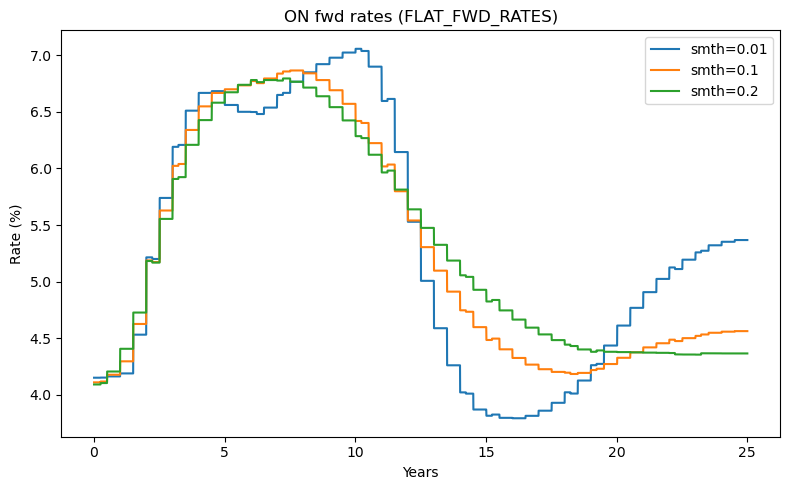

In [10]:
# grid of year fractions
years = np.linspace(1.0/365.0, 25.0, 25*365)

# build plot dates (list, not vectorized numpy)
plotDates = [settlement_date.add_years(float(y)) for y in years]

# If you're in Jupyter, keep this. Otherwise, remove the next line.
# %matplotlib widget

plt.figure(figsize=(8, 5))
for smoothness in smooth_params:
    ibor_curve = iborCurves[smoothness]
    iborCurveFwdRate = ibor_curve.fwd(plotDates)   # expects list of Dates
    plt.plot(years, iborCurveFwdRate * 100.0, label=f"smth={smoothness}")

# Use enum name if available, else str()
title_interp = getattr(interp_type, "name", str(interp_type))
plt.title(f"ON fwd rates ({title_interp})")
plt.xlabel("Years")
plt.ylabel("Rate (%)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Observe smoothness at work for zero rates (yields)

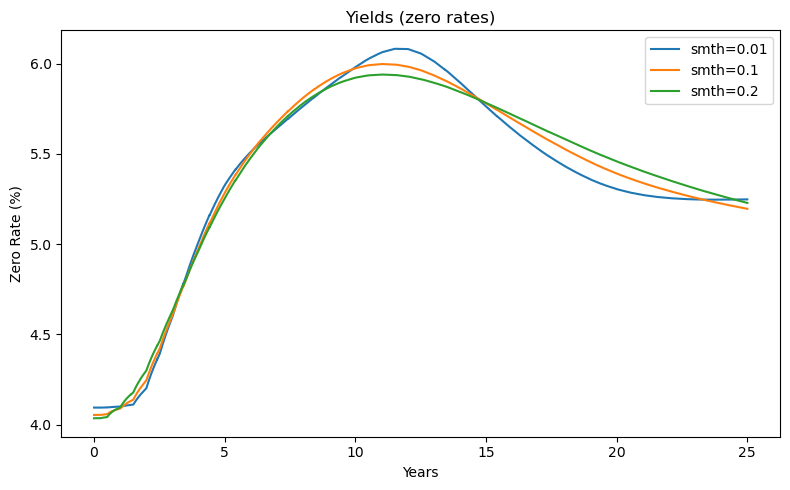

In [11]:
years = np.linspace(1.0/365.0, 25.0, 25*365)
plotDates = [settlement_date.add_years(float(y)) for y in years]

# If using Jupyter and want interactive zoom:
# %matplotlib widget

plt.figure(figsize=(8,5))
for smoothness in smooth_params:
    ibor_curve = iborCurves[smoothness]
    iborCurveZeroRate = ibor_curve.zero_rate(plotDates)
    plt.plot(years, iborCurveZeroRate*100.0, label=f"smth={smoothness}")

plt.xlabel("Years")
plt.ylabel("Zero Rate (%)")
plt.title("Yields (zero rates)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()



Compare output swap rates vs targets

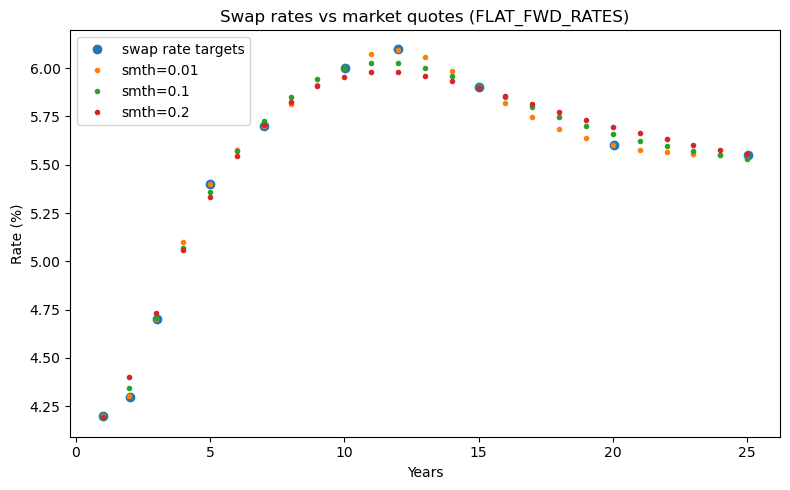

In [12]:
# %matplotlib widget   # keep only if you're in Jupyter

mat_years = np.linspace(1.0, 25.0, 25, endpoint=True)
mat_dates = [settlement_date.add_years(float(y)) for y in mat_years]  # list, not vectorized

# Market targets from your swaps
tgt_dates = [s.fixed_leg.maturity_dt for s in swaps]
tgt_years = [(d - valuation_date) / G_DAYS_IN_YEARS for d in tgt_dates]
tgt_rates = np.array([s.fixed_leg.cpn for s in swaps])

# Use the first swap as a template for conventions/effective date
tmpl = swaps[0]
eff_dt = tmpl.effective_dt
fix_freq = tmpl.fixed_leg.freq_type
fix_dc = tmpl.fixed_leg.dc_type

plt.figure(figsize=(8, 5))
plt.plot(tgt_years, tgt_rates * 100.0, 'o', label="swap rate targets")

for smoothness in smooth_params:
    ibor_curve = iborCurves[smoothness]
    iborCurveSwapRates = ibor_curve.swap_rate(eff_dt, mat_dates, fix_freq, fix_dc)
    plt.plot(mat_years, iborCurveSwapRates * 100.0, '.', label=f"smth={smoothness}")

title_interp = getattr(interp_type, "name", str(interp_type))
plt.title(f"Swap rates vs market quotes ({title_interp})")
plt.xlabel("Years")
plt.ylabel("Rate (%)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()
